In [1]:
import os
import sys
sys.path.append('../') # add parent directory to path
from src.train.utils_train import calc_laplace_df_dr_ker
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import seaborn as sns
sns.set_style("darkgrid")
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time
from tqdm import tqdm
from matplotlib import cm
import h5py
DTYPE = 'float32'
filename = '../data/ITER_like_equilibrium_dataset.h5'

2024-10-05 15:57:11.988506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 15:57:12.007219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 15:57:12.012622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 15:57:12.026465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 15:57:13.107774: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1728136634.851481   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728136634.888876   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728136634.889098   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
# # download datasets from gdrive, # uncomment if you want to download the dataset
# import gdown
# gdown.download(id="1-5KP7_OYIvDD_QXvIr5sDihVxZx1qJCN", output='data/ITER_like_equilibrium_dataset_sample.mat', quiet=False)
# gdown.download(id="1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue", output='data/ITER_like_equilibrium_dataset.mat', quiet=False)

In [3]:
# # generate h5 file from downloaded mat file # uncomment if needed
# data = io.loadmat('../data/ITER_like_equilibrium_dataset.mat')
# with h5py.File(filename,'w') as handle:
#     for k,v in data.items():
#         if '__' not in k:
#             print(k)
#             chunks = [1]
#             chunks.extend(list(v.shape[1:]))
#             handle.create_dataset(k, data=v, shape=v.shape, chunks=tuple(chunks), dtype='float64')

In [4]:
n_sample_train = 35000

with h5py.File(filename, 'r') as handle:
    DB_psi_pixel_test_ConvNet = handle['DB_psi_pixel_test_ConvNet'][()].astype(DTYPE)
    DB_meas_Bpickup_test_ConvNet = handle['DB_meas_Bpickup_test_ConvNet'][()].astype(DTYPE)
    DB_coils_curr_test_ConvNet = handle['DB_coils_curr_test_ConvNet'][()].astype(DTYPE)
    DB_p_test_ConvNet = handle['DB_p_test_ConvNet'][()].astype(DTYPE)
    RR_pixels = handle['RR_pixels'][()].astype(DTYPE)
    ZZ_pixels = handle['ZZ_pixels'][()].astype(DTYPE)
    DB_res_RHS_pixel_test_ConvNet = handle['DB_res_RHS_pixel_test_ConvNet'][()].astype(DTYPE)
    DB_separatrix_200_test_ConvNet = handle['DB_separatrix_200_test_ConvNet'][()].astype(DTYPE)
    DB_Jpla_pixel_test_ConvNet = handle['DB_Jpla_pixel_test_ConvNet'][()].astype(DTYPE)
y_data = DB_psi_pixel_test_ConvNet
X_data = np.column_stack((DB_meas_Bpickup_test_ConvNet, DB_coils_curr_test_ConvNet)) #, DB_f_test_ConvNet, DB_p_test_ConvNet ))
# Save RR_pixels, ZZ_pixels
outdir = '../data/'
dict_save = {'RR_pixels':RR_pixels,'ZZ_pixels':ZZ_pixels}
nr,nz = RR_pixels.shape
io.savemat('{}data_geo_Dataset_NeuralOpt_super_res_{}x{}.mat'.format(outdir,nr,nz),dict_save)   

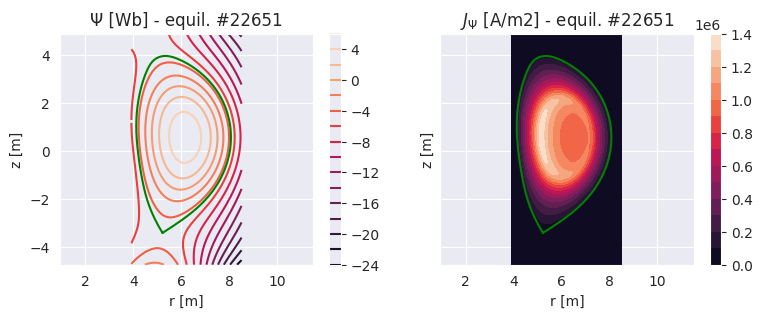

In [5]:
# plot dataset example
for i in range(0,1):
    ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    img = axs[0].contour(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[0].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('Ψ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RR_pixels,ZZ_pixels,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_Ψ$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')

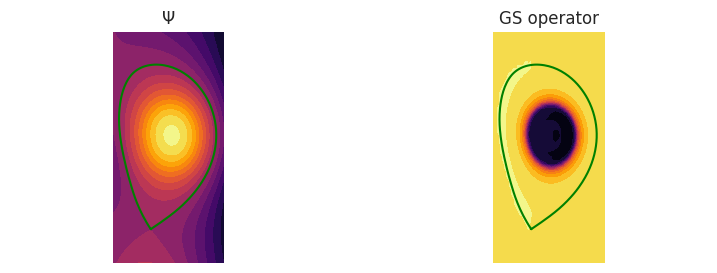

In [6]:
# plot Ψ and GS operator
cmap = cm.inferno
for i in range(0,1):
    ind_plot = np.random.randint(0,DB_Jpla_pixel_test_ConvNet.shape[0],1)[0]
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    img = axs[0].contourf(RR_pixels,ZZ_pixels,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15,cmap=cmap)
    axs[0].plot( DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[0].set_xlim([RR_pixels.min(),RR_pixels.max()])
    axs[0].set_ylim([ZZ_pixels.min(),ZZ_pixels.max()])
    axs[0].axis('equal')
    axs[0].set_axis_off()
    axs[0].set_title('Ψ')
    qq = DB_res_RHS_pixel_test_ConvNet[ind_plot,:,:]
    img = axs[1].contourf(RR_pixels,ZZ_pixels,qq,15,cmap=cmap)
    axs[1].set_title('GS operator')
    axs[1].axis('equal')
    axs[1].set_xlim([RR_pixels.min(),RR_pixels.max()])
    axs[1].set_ylim([ZZ_pixels.min(),ZZ_pixels.max()])
    axs[1].axis('equal')
    axs[1].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[1].set_axis_off()
    # plt.savefig('./figures/equil_and_GSope', dpi=300)

In [7]:
### train-test split
id_train = np.load('{}/id_train.npy'.format(outdir))
id_test = np.load('{}/id_test.npy'.format(outdir))
### Standardize input data
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

In [8]:
# utils functions
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def sample_random_subgrids(RR_pixels,ZZ_pixels,nr=64,nz=64):
  delta_r_min = .33*(RR_pixels.max()-RR_pixels.min())
  delta_r_max = .75*(RR_pixels.max()-RR_pixels.min())
  delta_z_min = .2*(ZZ_pixels.max()-ZZ_pixels.min())
  delta_z_max = .75*(ZZ_pixels.max()-ZZ_pixels.min())
  delta_r = np.random.uniform(delta_r_min,delta_r_max,1)
  r0 = np.random.uniform(RR_pixels.min(),RR_pixels.min()+delta_r_max-delta_r,1)
  delta_z = np.random.uniform(delta_z_min,delta_z_max,1)
  z0 = np.random.uniform(ZZ_pixels.min(),ZZ_pixels.min()+delta_z_max-delta_z,1)
  rr = np.linspace(r0,r0+delta_r,nr)
  zz = np.linspace(z0,z0+delta_z,nz)
  rr_grid, zz_grid = np.meshgrid(rr,zz,indexing='xy')
  return rr_grid, zz_grid

def get_box_from_grid(rr_grid, zz_grid):
  rm, rM, zm, zM = rr_grid.min(), rr_grid.max(), zz_grid.min(), zz_grid.max()
  return np.array([[rm,zm],[rM,zm],[rM,zM],[rm,zM],[rm,zm]])

def interp_fun(f, RR_pixels, ZZ_pixels, rr_grid, zz_grid, kind='quintic'):
  x_pts, y_pts = RR_pixels[0,:], ZZ_pixels[:,0]
  interp_func = RegularGridInterpolator((x_pts, y_pts), f.T, method=kind)
  pts = np.column_stack((rr_grid.flatten(), zz_grid.flatten()))
  f_int = interp_func(pts).reshape(rr_grid.shape)
  return f_int

def def_grids_and_interp(f, rhs, RR_pixels, ZZ_pixels, nr=64, nz=64, kind='quintic'):
  rr_grid, zz_grid = sample_random_subgrids(RR_pixels,ZZ_pixels,nr,nz)
  f_grid = interp_fun(f,RR_pixels,ZZ_pixels,rr_grid, zz_grid,kind=kind)
  rhs_grid = interp_fun(rhs,RR_pixels,ZZ_pixels,rr_grid, zz_grid,kind=kind)
  return rr_grid, zz_grid, f_grid, rhs_grid

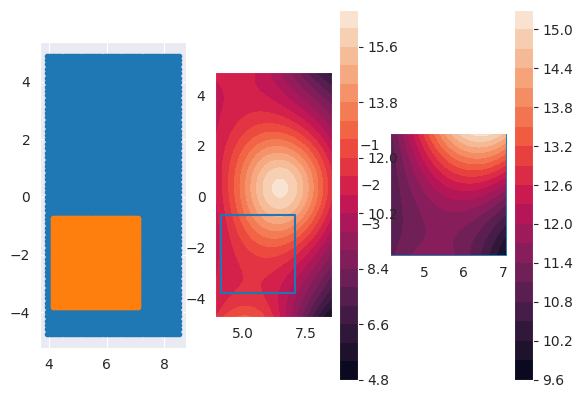

In [9]:
f = y_data[0,:,:]
rr_grid, zz_grid = sample_random_subgrids(RR_pixels,ZZ_pixels)
box = get_box_from_grid(rr_grid, zz_grid)
f_grid = interp_fun(f, RR_pixels, ZZ_pixels, rr_grid, zz_grid, kind='quintic')

fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].set_aspect('equal', 'box')

im = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[1])

im = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])
plt.show()

In [10]:
'''
The full training dataset is ~60k equilibria. We select 35k equilibria on the full grid
and 35k equilibria to be resampled on randomly generated sub-grids. These two datasets 
are then put together ans shuffled.

_all_domain -> quantities related to the original grid
_super_res -> quantities related to random sub-grids

It woul be nice to explore how the performance changes using data different from the 
aforementioned 35k/35k.
'''
np.random.seed(42)
ind_all_domain = np.random.choice(id_train,n_sample_train)
ind_super_res = np.random.choice(id_train,n_sample_train)

n_all_domain = ind_all_domain.shape[0]
n_super_res = ind_super_res.shape[0]

print(f'{n_all_domain} equil on the original grid')
print(f'{n_super_res} equil on random sub-grids')

y_train_all_domain = y_data[ind_all_domain,:,:]
X_train_all_domain = X_data[ind_all_domain,:]
res_RHS_pixel_train_all_domain = DB_res_RHS_pixel_test_ConvNet[ind_all_domain,:,:]

y_test_all_domain = y_data[id_test,:,:]
X_test_all_domain = X_data[id_test,:]
res_RHS_pixel_test_all_domain = DB_res_RHS_pixel_test_ConvNet[id_test,:,:]

f_for_super_res = y_data[ind_super_res,:,:]
rhs_for_super_res = DB_res_RHS_pixel_test_ConvNet[ind_super_res,:,:]

X_train_super_res = X_data[ind_super_res,:]
y_train_super_res = np.zeros((n_super_res,64,64), dtype=DTYPE)
rhs_train_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
RR_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)
ZZ_grid_super_res = np.zeros_like(y_train_super_res, dtype=DTYPE)

35000 equil on the original grid
35000 equil on random sub-grids


In [11]:
# interpolate f and rhs on random sub-grids, NOTE: very slow if using 'quintic' method
t_start = time()
for i in tqdm(range(f_for_super_res.shape[0]), miniters = 0):
    rr_grid, zz_grid, f_grid, rhs_grid = def_grids_and_interp(f_for_super_res[i,...],rhs_for_super_res[i,...],RR_pixels,ZZ_pixels, kind='quintic')
    RR_grid_super_res[i,:,:] = rr_grid
    ZZ_grid_super_res[i,:,:] = zz_grid
    y_train_super_res[i,:,:] = f_grid
    rhs_train_super_res[i,:,:] = rhs_grid
t_elapsed = time() - t_start
print(f't_elapsed = {t_elapsed}, time_per_step = {t_elapsed/n_super_res}')
RR_grid_all_domain = np.tile(RR_pixels,(n_all_domain,1,1))
ZZ_grid_all_domain = np.tile(ZZ_pixels,(n_all_domain,1,1))

100%|██████████| 35000/35000 [00:28<00:00, 1207.38it/s]

t_elapsed = 28.99099349975586, time_per_step = 0.0008283140999930245


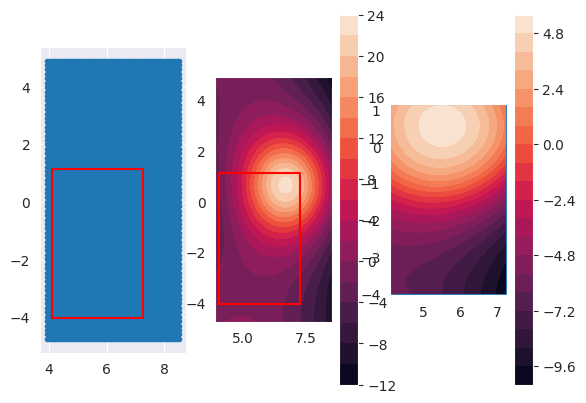

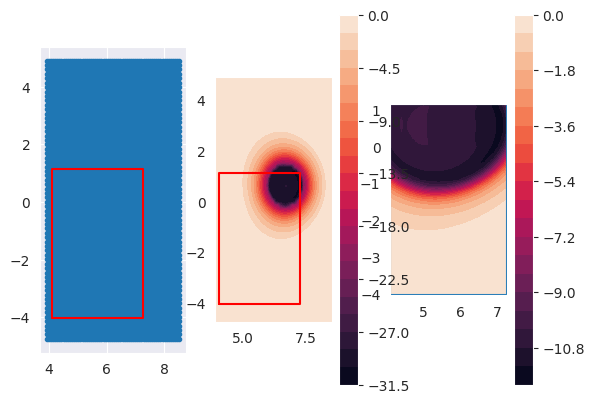

In [12]:
### Check re-sampled equils
import random
i = random.randint(0,n_super_res)

f = f_for_super_res[i,:,:]
rhs = rhs_for_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
rr_grid = RR_grid_super_res[i,:,:]
box = get_box_from_grid(rr_grid, zz_grid)

fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
# ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].plot(box[:,0],box[:,1],c='r')
ax[0].set_aspect('equal', 'box')
im = ax[1].contourf(RR_pixels, ZZ_pixels, f, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[1])
im = ax[2].contourf(rr_grid, zz_grid, f_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])
plt.show()

fig,ax = plt.subplots(1,3)
ax[0].scatter(RR_pixels.ravel(), ZZ_pixels.ravel(), marker='.')
# ax[0].scatter(rr_grid.ravel(), zz_grid.ravel(), marker='.')
ax[0].plot(box[:,0],box[:,1],c='r')
ax[0].set_aspect('equal', 'box')
im = ax[1].contourf(RR_pixels, ZZ_pixels, rhs, 20)
ax[1].set_aspect('equal', 'box')
ax[1].plot(box[:,0],box[:,1],c='r')
plt.colorbar(im,ax=ax[1])
im = ax[2].contourf(rr_grid, zz_grid, rhs_grid, 20)
ax[2].set_aspect('equal', 'box')
ax[2].plot(box[:,0],box[:,1])
plt.colorbar(im,ax=ax[2])
plt.show()

In [13]:
# compute kernels for the GS equation train
from src.train.utils_train import calc_laplace_df_dr_ker
''' Compute kernels for GS Equation for the qeuils on the sub-grids (dr,dz is grid-dependent), 
otherwise we would have to compute them on the fly during each training step '''
y_train = np.row_stack([y_train_all_domain,y_train_super_res])
X_train = np.row_stack([X_train_all_domain,X_train_super_res])
res_RHS_pixel_train = np.row_stack([res_RHS_pixel_train_all_domain,rhs_train_super_res])
RR_pixel_train = np.row_stack([RR_grid_all_domain,RR_grid_super_res])
ZZ_pixel_train = np.row_stack([ZZ_grid_all_domain,ZZ_grid_super_res])
print(X_train.shape, y_train.shape, res_RHS_pixel_train[:,1:-1,1:-1].shape, RR_pixel_train.shape, ZZ_pixel_train.shape)
Laplace_kernel = np.zeros((y_train.shape[0],3,3),dtype=DTYPE)
Df_dr_kernel = np.zeros((y_train.shape[0],3,3),dtype=DTYPE)
hrs, hzs = RR_pixel_train[:,1,2] - RR_pixel_train[:,1,1], ZZ_pixel_train[:,2,1] - ZZ_pixel_train[:,1,1]
for i, (hr, hz) in enumerate(tqdm(zip(hrs, hzs), total=len(hrs))):
    Laplace_kernel[i,:,:], Df_dr_kernel[i,:,:] = calc_laplace_df_dr_ker(hr, hz)
### Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train, res_RHS_pixel_train[:,1:-1,1:-1], RR_pixel_train, ZZ_pixel_train, Laplace_kernel, Df_dr_kernel)).shuffle(42)#.batch(batch_size=1024)
tf.data.Dataset.save(train_ds, '{}tf_Dataset_train_NeuralOpt_{}x{}_{}_samples.data'.format(outdir,nr,nz, X_train.shape[0]))

(70000, 201) (70000, 64, 64) (70000, 62, 62) (70000, 64, 64) (70000, 64, 64)


100%|██████████| 70000/70000 [00:01<00:00, 36364.83it/s]
I0000 00:00:1728136693.999542   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728136694.000049   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728136694.000223   24050 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728136694.096840   24050 cuda_

In [14]:
# compute kernels for the GS equation test
y_test = y_test_all_domain
X_test = X_test_all_domain
res_RHS_pixel_test = res_RHS_pixel_test_all_domain
RR_pixel_test = np.tile(RR_pixels,(X_test.shape[0],1,1))
ZZ_pixel_test = np.tile(ZZ_pixels,(X_test.shape[0],1,1))
Laplace_kernel = np.zeros((y_test.shape[0],3,3),dtype=DTYPE)
Df_dr_kernel = np.zeros((y_test.shape[0],3,3),dtype=DTYPE)
hrs, hzs = RR_pixel_test[:,1,2] - RR_pixel_test[:,1,1], ZZ_pixel_test[:,2,1] - ZZ_pixel_test[:,1,1]
for i, (hr, hz) in enumerate(tqdm(zip(hrs, hzs), total=len(hrs))):
    Laplace_kernel[i,:,:], Df_dr_kernel[i,:,:] = calc_laplace_df_dr_ker(hr, hz)
# Dataset with equilibria on the entire domain
train_ds = tf.data.Dataset.from_tensor_slices(( X_test, y_test, res_RHS_pixel_test[:,1:-1,1:-1], RR_pixel_test, ZZ_pixel_test, Laplace_kernel, Df_dr_kernel)).shuffle(42)
tf.data.Dataset.save(train_ds, '{}tf_Dataset_test_NeuralOpt_{}x{}_{}_samples.data'.format(outdir,nr,nz, y_test.shape[0]))

100%|██████████| 16398/16398 [00:00<00:00, 36546.84it/s]
